# Notebook d'exploration

## Mise en place et informations générales

Librairies et paramétrages utilisés au cours du notebook 

In [1]:
from functools import reduce
import re
import string

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use(style='ggplot')
mpl.rcParams['figure.dpi'] = 100
pd.options.mode.chained_assignment = None

Chargeons les données et affichons un aperçu

In [3]:
data = pd.read_csv('data/movie_metadata.csv')
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


Décrivons brièvement les différentes variables: noms, nombre de valeurs non-manquantes, type

In [4]:
data.sort_index(axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
actor_1_facebook_likes       5036 non-null float64
actor_1_name                 5036 non-null object
actor_2_facebook_likes       5030 non-null float64
actor_2_name                 5030 non-null object
actor_3_facebook_likes       5020 non-null float64
actor_3_name                 5020 non-null object
aspect_ratio                 4714 non-null float64
budget                       4551 non-null float64
cast_total_facebook_likes    5043 non-null int64
color                        5024 non-null object
content_rating               4740 non-null object
country                      5038 non-null object
director_facebook_likes      4939 non-null float64
director_name                4939 non-null object
duration                     5028 non-null float64
facenumber_in_poster         5030 non-null float64
genres                       5043 non-null object
gross                        4159 no

Nombre de valeurs manquantes pour chaque variable en nombre décroissant

In [5]:
data.isnull().sum().sort_values(ascending=False)

gross                        884
budget                       492
aspect_ratio                 329
content_rating               303
plot_keywords                153
title_year                   108
director_facebook_likes      104
director_name                104
num_critic_for_reviews        50
actor_3_facebook_likes        23
actor_3_name                  23
num_user_for_reviews          21
color                         19
duration                      15
actor_2_facebook_likes        13
actor_2_name                  13
facenumber_in_poster          13
language                      12
actor_1_name                   7
actor_1_facebook_likes         7
country                        5
imdb_score                     0
cast_total_facebook_likes      0
num_voted_users                0
movie_title                    0
movie_imdb_link                0
genres                         0
movie_facebook_likes           0
dtype: int64

## Nettoyage et _Feature Engineering_

Gardons une copie de nos données brutes avant de procéder à tout changement.

In [6]:
save = data.copy()

Maintenant, traitons les différentes variables mises à notre disposition afin qu'elles soient utilisables par la suite dans la phase de modélisation. Nous les traitons dans trois sous-sections:
- variables catégorielles
- variables numériques
- mise en forme finale du tableau de données

### Variables catégorielles

#### _color_

In [7]:
data['color'].value_counts(dropna=False) / len(data)

Color               0.954789
 Black and White    0.041444
NaN                 0.003768
Name: color, dtype: float64

Cette variable possède deux modalités: nous la considérons donc comme binaire. Nous transformons ses valeurs en numérique et remplaçons le peu de valeurs manquantes par modalité majoritaire.

In [8]:
data['color'] = (data['color'].fillna(data['color'].mode()[0])
                 .map(lambda x: 1 if x=='Color' else 0))

#### _facenumber in poster_

In [9]:
data['facenumber_in_poster'].value_counts(dropna=False)

 0.0     2152
 1.0     1251
 2.0      716
 3.0      380
 4.0      207
 5.0      114
 6.0       76
 7.0       48
 8.0       37
 9.0       18
NaN        13
 10.0      10
 15.0       6
 11.0       5
 12.0       4
 13.0       2
 19.0       1
 14.0       1
 31.0       1
 43.0       1
Name: facenumber_in_poster, dtype: int64

Compte-tenu du grand nombre de modalités, nous discrétisation de la variable de manière à lui donner un sens plus utile: 
- aucune personne, 
- une personne, 
- plusieurs personnes

Aussi, nous remplaçons les valeurs manquantes par le mode.

In [10]:
def discretize_facenumber(x):
    
    if x == 0:
        return 'none'
    elif x == 1:
        return 'one'
    else:
        return 'more'
    
data['facenumber_in_poster'] = (data['facenumber_in_poster'].fillna(data['facenumber_in_poster'].mode()[0])
                                .map(discretize_facenumber, na_action='ignore'))
data['facenumber_in_poster'].value_counts(dropna=False)

none    2165
more    1627
one     1251
Name: facenumber_in_poster, dtype: int64

Créeons des _dummy variables_ des catégories crées et les ajoutons-les à la dataframe originale

In [11]:
data = pd.concat([data, pd.get_dummies(data['facenumber_in_poster'], prefix='posterfaces')], axis=1) 

#### *genres*

Récupérons une liste de tous les genres uniques existants

In [12]:
all_genres = data['genres'].transform(lambda x: x.split('|'));
genres = list(set(reduce(lambda x,y:x+y, all_genres))) # retrieve unique genres
genres

['Short',
 'History',
 'Sci-Fi',
 'Thriller',
 'Mystery',
 'Drama',
 'News',
 'Animation',
 'Game-Show',
 'Family',
 'Crime',
 'Reality-TV',
 'Adventure',
 'Musical',
 'Film-Noir',
 'Comedy',
 'War',
 'Action',
 'Sport',
 'Horror',
 'Fantasy',
 'Music',
 'Documentary',
 'Western',
 'Romance',
 'Biography']

Créeons de nouvelles _dummy variables_ pour chacun d'entre eux

In [13]:
new_vars = list(map(lambda x: 'genre_' + x.lower(), genres)) 

for var in new_vars:
    data[var] = 0

Indiquons dans nos _dummy variables_ créées à quel(s) genre(s) chaque film appartient 

In [14]:
# Récupérer les genres de chaque film sous forme de liste
each_genres = (data['genres'].transform(lambda x: x.split('|'))
               .map(lambda x: ['genre_' + g.lower() for g in x]))

# Assigner dummy values
for index, _ in data.iterrows():
    data.loc[index, each_genres[index]] = 1

#### _content rating_

In [15]:
data['content_rating'].value_counts(dropna=False)

R            2118
PG-13        1461
PG            701
NaN           303
Not Rated     116
G             112
Unrated        62
Approved       55
TV-14          30
TV-MA          20
TV-PG          13
X              13
TV-G           10
Passed          9
NC-17           7
GP              6
M               5
TV-Y            1
TV-Y7           1
Name: content_rating, dtype: int64

Regroupements de modalités faites en fonction de leur signification
- TV-PG = PG
- TV-14 ~ PG-13
- TV-MA = NC-17
- TV-G = G
- TV-Y7, pour les enfants = G
- TV-Y, pour les enfants = G
- M = GP = PG
- X = NC-17


- Approved (approved for film exhibition) = mettre NA
- Passed (approved for film exhibition) = mettre NA


- Not rated: mettre NA
- Unrated: mettre NA


Explications des labels généraux que nous gardons
- G: general
- PG: parental guidance (pas encourgé pour jeunes enfants)
- PG-13: strong  parental guidance (fortement pas encouragé pour -13 ans)
- R: need adult in room
- NC-17: +17 y/o only

Aussi, nous créeons une variable binaire additionnelle signifiant si un élément a été diffusé originellement sur 'petit écran' (TV) ou non.

Sources:
    
- [Système de notation de films américain](http://bit.ly/2F0j4eT)
- [Système de notation TV américain](http://bit.ly/2EYOeDA)

In [16]:
# Créer une variable binaire pour dénoter les instances qui sont des séries
TV_labels = ['TV-PG', 'TV-14', 'TV-MA', 'TV-G', 'TV-Y7', 'TV-Y']
data['is_TV'] = np.where(data['content_rating'].isin(TV_labels), 1, 0)


# Grouper les recommendations d'âge
replace_ratings = {'TV-G': 'G', 'TV-Y7': 'G', 'TV-Y': 'G',
                   'TV-PG': 'PG', 'GP': 'PG', 'M': 'PG', 
                   'TV-14': 'PG-13', 
                   'TV-MA': 'NC-17', 'X': 'NC-17', 
                   'Approved': np.nan, 'Passed': np.nan, 'Not Rated': np.nan, 'Unrated': np.nan}


# Opérer les changements sur la dataframe
data['content_rating'] = pd.Categorical(data['content_rating'].replace(replace_ratings), 
                                        categories=['G', 'PG', 'PG-13', 'R', 'NC-17'], 
                                        ordered=True)
data['content_rating'].value_counts(dropna=False)

R        2118
PG-13    1491
PG        725
NaN       545
G         124
NC-17      40
Name: content_rating, dtype: int64

Remplaçons les valeurs manquantes par la modalité la plus fréquente, puis créeons des _dummy variables_ des catégories fusionnées, que nous ajouterons à la dataframe principale

In [17]:
data['content_rating'].fillna(value=data['content_rating'].mode()[0], inplace=True)
content_dummies = pd.get_dummies(data['content_rating'], prefix='rating')
data = pd.concat([data, content_dummies], axis=1)

#### _language_

Distribution de la variable

In [18]:
data['language'].value_counts(dropna=False) / len(data)

English       0.932778
French        0.014476
Spanish       0.007932
Hindi         0.005552
Mandarin      0.005156
German        0.003768
Japanese      0.003569
NaN           0.002380
Russian       0.002181
Italian       0.002181
Cantonese     0.002181
Korean        0.001586
Portuguese    0.001586
Swedish       0.000991
Hebrew        0.000991
Danish        0.000991
Arabic        0.000991
Polish        0.000793
Dutch         0.000793
Norwegian     0.000793
Persian       0.000793
Chinese       0.000595
Thai          0.000595
Aboriginal    0.000397
Zulu          0.000397
None          0.000397
Romanian      0.000397
Icelandic     0.000397
Indonesian    0.000397
Dari          0.000397
Mongolian     0.000198
Tamil         0.000198
Vietnamese    0.000198
Bosnian       0.000198
Hungarian     0.000198
Kazakh        0.000198
Filipino      0.000198
Urdu          0.000198
Kannada       0.000198
Maya          0.000198
Czech         0.000198
Dzongkha      0.000198
Swahili       0.000198
Aramaic    

- Sur l'ensemble des données, beaucoup d'observations groupées dans de la modalité `English`.
- On choisit de binariser la variable: 1 si `English`, 0 si autre langue
- On impute les valeurs manquantes par la modalité principale 

In [19]:
data['language'] = data['language'].map(lambda x: 1 if x=='English' else 0)
data['language'].value_counts(dropna=False)

1    4704
0     339
Name: language, dtype: int64

#### _country_

In [20]:
data['country'].value_counts(dropna=False)

USA                     3807
UK                       448
France                   154
Canada                   126
Germany                   97
Australia                 55
India                     34
Spain                     33
China                     30
Italy                     23
Japan                     23
Hong Kong                 17
Mexico                    17
New Zealand               15
South Korea               14
Ireland                   12
Russia                    11
Denmark                   11
South Africa               8
Brazil                     8
Norway                     8
Sweden                     6
Netherlands                5
Thailand                   5
NaN                        5
Poland                     5
Belgium                    4
Argentina                  4
Iran                       4
Romania                    4
                        ... 
Taiwan                     2
Hungary                    2
Finland                    1
Libya         

On remarque une distribution similaire à `language`, avec une sur-représentation du monde anglophone, et dans des proportions proches. Nous considérons que l'information apportée par cette variable est similaire que celle apportée par la variable `language`, on décide donc de ne pas la garder.

#### _Plot keywords_

In [21]:
data['plot_keywords']

0                  avatar|future|marine|native|paraplegic
1       goddess|marriage ceremony|marriage proposal|pi...
2                     bomb|espionage|sequel|spy|terrorist
3       deception|imprisonment|lawlessness|police offi...
4                                                     NaN
5       alien|american civil war|male nipple|mars|prin...
6               sandman|spider man|symbiote|venom|villain
7       17th century|based on fairy tale|disney|flower...
8       artificial intelligence|based on comic book|ca...
9                        blood|book|love|potion|professor
10      based on comic book|batman|sequel to a reboot|...
11      crystal|epic|lex luthor|lois lane|return to earth
12      action hero|attempted rape|bond girl|official ...
13      box office hit|giant squid|heart|liar's dice|m...
14                  horse|outlaw|texas|texas ranger|train
15      based on comic book|british actor playing amer...
16      brother brother relationship|brother sister re...
17        alie

À première vue, on peut remarquer qu'il existe beaucoup de mots-clés différents sur l'ensemble de films. Prendre en compte cette variable risquerait de générer beaucoup de *bruit*, et non pas des *patterns* généraux. Nous choisissons de la supprimer.

#### _'Main Crew' variables_

Il y a un groupe de variables catégorielles concernant la 'vitrine' du film, à savoir ses membres qui seront les plus exposés médiatiquement
- `director_name`
- `actor_1_name` 
- `actor_2_name` 
- `actor_3_name`

Prendre ces variables telles quelles introduirait beaucoup de bruit, car elles possèdent beaucoup de modalités, étant donné la diversité de notre base de films. Pour donner un sens plus utile à ces variables, nous remplaçons chacune de leurs modalités par leur fréquence relative, traduisant pour chacune leur popularité relative dans la distribution d'une variable.

In [22]:
crew_variables = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']

for variable in crew_variables:    
    # remplace chaque modalité par sa fréquence d'apparence
    data[variable] = (data[variable].map(lambda x: data[variable].value_counts()[x], na_action='ignore') 
                      .divide(data[variable].value_counts()[0]))

Affichons la distributions des variables transformées obtenues

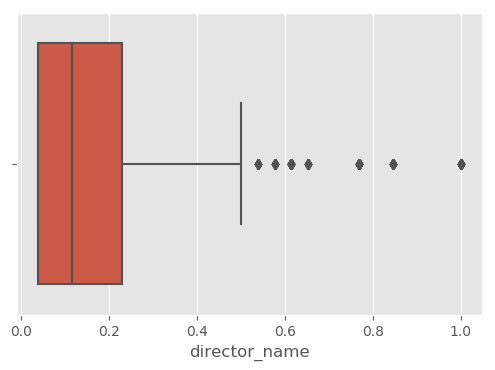

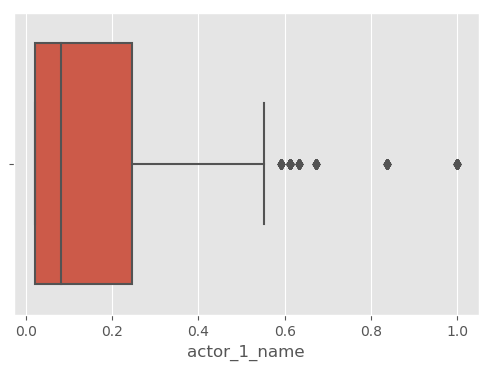

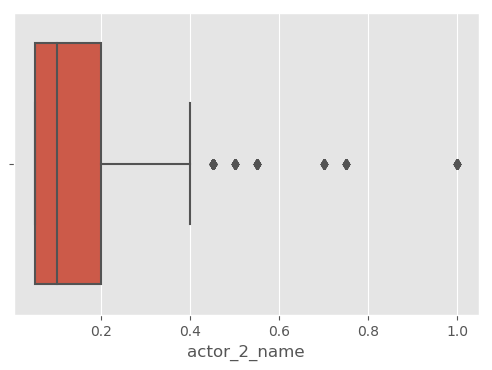

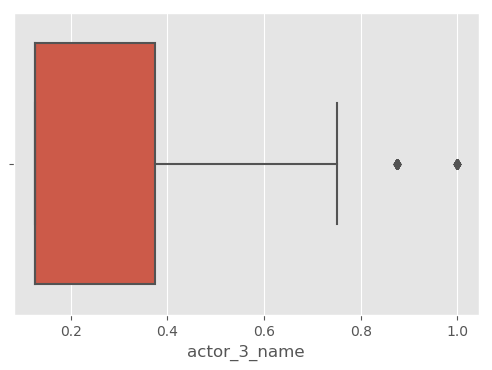

In [23]:
for var in crew_variables:
    plt.figure()
    sns.boxplot(x=var, data=data)

Pour chacune de ces variables il reste des valeurs manquantes

In [24]:
data[crew_variables].isnull().sum()

director_name    104
actor_1_name       7
actor_2_name      13
actor_3_name      23
dtype: int64

Nous remplaçons chacune de ces valeurs manquantes par la valeur médiane de leur variable transformée (étant donné que les distributions sont biaisées nous n'utilisons pas la moyenne)

In [25]:
data[crew_variables] = data[crew_variables].fillna(data[crew_variables].median())

### Variables numériques - 1

Nous regroupons ensemble les variables qui traduisent la popularité du film auprès du public et des critiques, étant donné qu'elles passent par des phases de *pre-processing* similaires.

In [26]:
num_easy = ['num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'imdb_score', 'movie_facebook_likes', 
            'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'cast_total_facebook_likes']

Affichons la distribution de chacune des variables à l'aide de boxplots

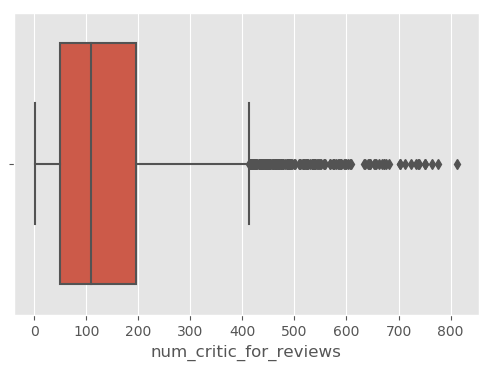

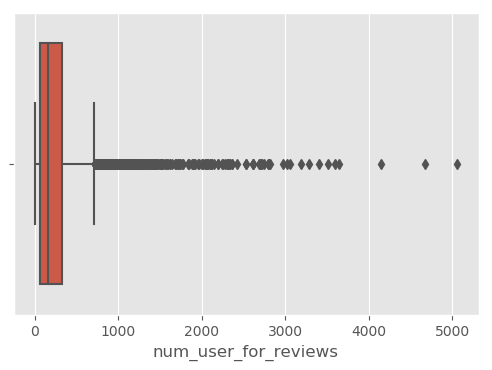

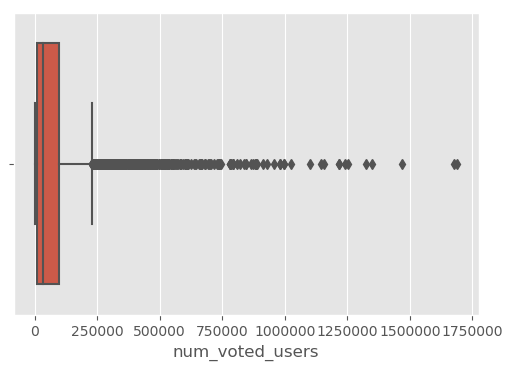

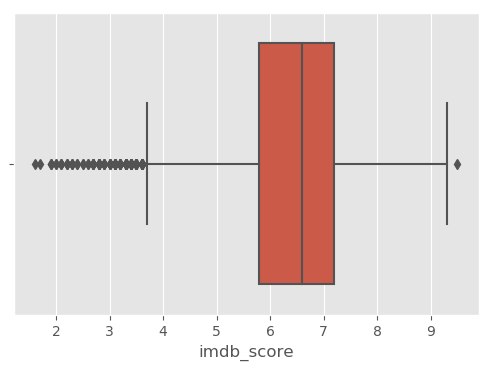

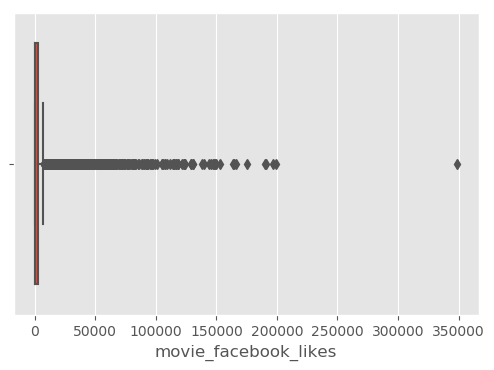

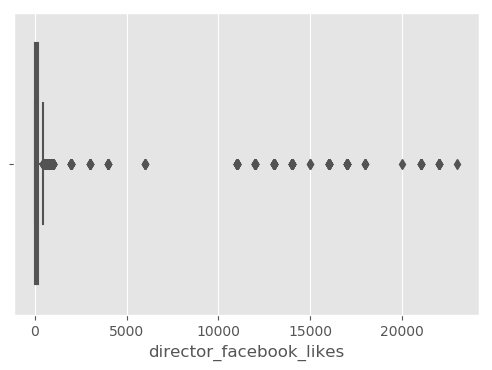

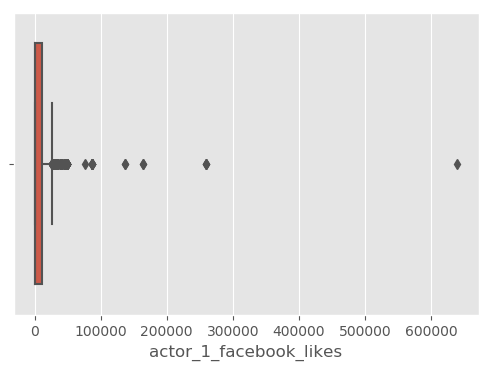

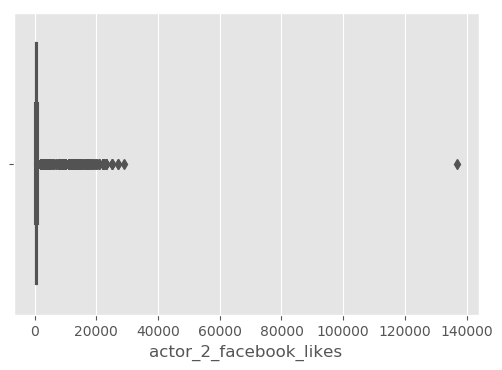

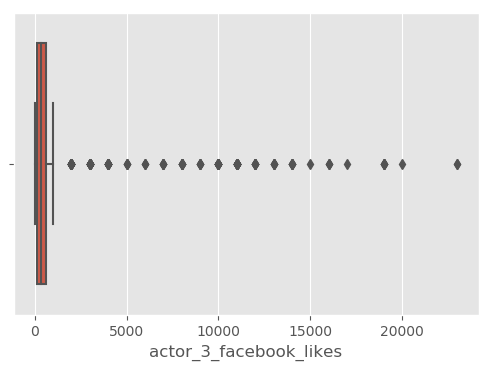

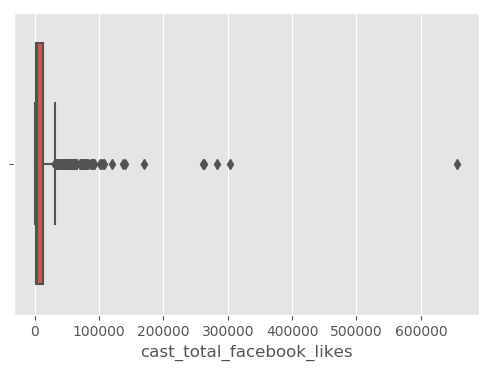

In [27]:
for var in num_easy:
    plt.figure()
    sns.boxplot(x=var, data=data)

Nous choisissons là encore de remplacer le peu de valeurs manquantes dans chaque variable par leur médiane

In [28]:
data[num_easy] = data[num_easy].fillna(data[num_easy].median())

Aussi, nous mettons à l'échelle l'étendue de chacune de ces variables dans un intervalle entre [0, 1], afin de s'assurer que toutes les variables aient le même poids dans les modélisations à venir. 

In [29]:
scaler = MinMaxScaler()
data[num_easy] = scaler.fit_transform(data[num_easy])

### Variables numériques - 2

#### _aspect ratio_

In [30]:
data['aspect_ratio'].value_counts(dropna=False)

 2.35     2360
 1.85     1906
NaN        329
 1.78      110
 1.37      100
 1.33       68
 1.66       64
 16.00      45
 2.20       15
 2.39       15
 4.00        7
 2.00        5
 2.40        3
 1.75        3
 2.76        3
 2.55        2
 1.50        2
 2.24        1
 1.20        1
 1.18        1
 1.44        1
 1.77        1
 1.89        1
Name: aspect_ratio, dtype: int64

Après plusieurs recherches, les catégories `16.00` and `4.00` ne correspondent pas à des ratios de format d'image connus. Nous les remplaçons par des valeurs manquantes pour s'assurer qu'elles ne déforment pas la distribution.

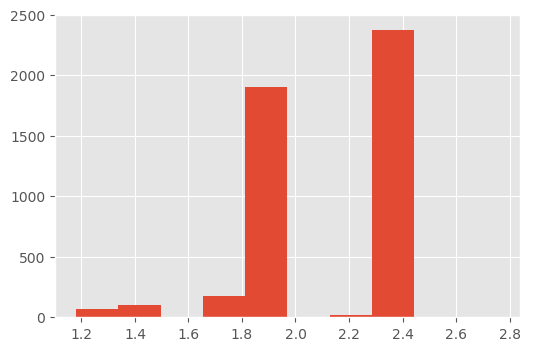

In [31]:
data['aspect_ratio'].replace({16.00: np.nan, 4.00: np.nan}, inplace=True)
data['aspect_ratio'].hist();

Nous remplaçons les valeurs manquantes restantes de la variable par sa moyenne, et rammenons ses valeurs dans un intervalle entre [0, 1]

In [32]:
data['aspect_ratio'] = data['aspect_ratio'].fillna(data['aspect_ratio'].mean())

#### _Duration_

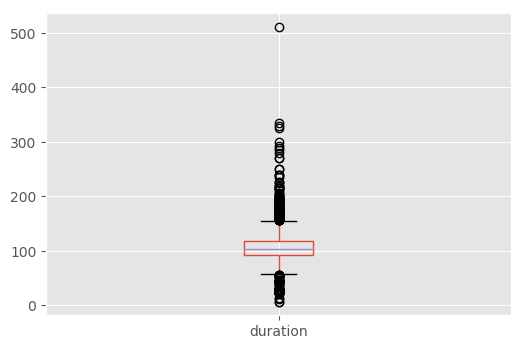

In [33]:
data['duration'].plot(kind='box');

In [34]:
data.sort_values(by='duration', ascending=False).head()

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,aspect_ratio,budget,cast_total_facebook_likes,color,...,genre_documentary,genre_western,genre_romance,genre_biography,is_TV,rating_G,rating_PG,rating_PG-13,rating_R,rating_NC-17
1710,0.000230,0.020408,0.000460,0.05,0.002217,0.125,2.084723,NaN,0.000467,1,...,0,0,0,0,0,0,0,0,1,0
2466,0.001402,0.020408,0.000219,0.05,0.001304,0.125,2.350000,NaN,0.001571,1,...,0,0,0,1,0,0,0,0,1,0
1501,0.001325,0.081633,0.004920,0.05,0.029217,0.500,1.660000,35000000.0,0.004914,1,...,0,0,0,0,0,0,0,0,1,0
1144,0.018750,0.367347,0.006197,0.15,0.029478,0.250,2.350000,44000000.0,0.021706,1,...,0,1,0,0,0,0,0,0,1,0
3311,0.000011,0.020408,0.000044,0.05,0.000261,0.125,1.850000,400000000.0,0.000049,1,...,0,0,0,0,0,0,0,0,1,0


In [35]:
data['duration'] = data['duration'].fillna(data['duration'].median())

#### _title year_

In [36]:
data['title_year'].describe()

count    4935.000000
mean     2002.470517
std        12.474599
min      1916.000000
25%      1999.000000
50%      2005.000000
75%      2011.000000
max      2016.000000
Name: title_year, dtype: float64

Il ne semble pas il y avoir de valeurs fantaisistes. Peu de valeurs manquantes

In [37]:
data['title_year'].map(pd.isnull).value_counts()

False    4935
True      108
Name: title_year, dtype: int64

Remplaçons-les par la médiane de la variable

In [38]:
data['title_year'] = data['title_year'].fillna(data['title_year'].median())

#### Budget

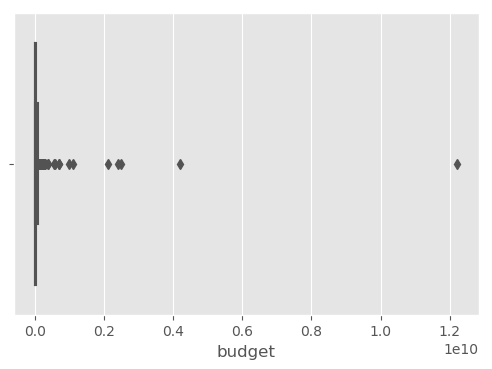

In [39]:
sns.boxplot(data['budget']);

Problème pour les valeurs de cette variable: elles n'ont pas toutes été converties dans la même devise, ce qui la rend inexploitable. On choisit de la supprimer pour cette raison

Là encore, nous adaptons les étendues de ces variables pour les mettre dans un intervalle entre [0,1] pour les raisons données précédemment.

In [40]:
num_hard = ['aspect_ratio', 'duration', 'title_year']
scaler = MinMaxScaler()
data[num_hard] = scaler.fit_transform(data[num_hard])

### Derniers ajustements

#### Mise en forme

Extraire `id` depuis lien imbd, et l'utiliser pour repérer et supprimer les doublons dans les entrées

In [41]:
data['id'] = data['movie_imdb_link'].map(lambda x: x.split('/')[4][2:])

data = data[~data.duplicated('id')]

Mettre cet id - avec le nom des films - dans un tableau de données séparé.

In [42]:
movies = data[['id', 'movie_title']]
movies['movie_title'] = movies['movie_title'].transform(lambda x: x[:-1])
to_search = movies['movie_title'].transform(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower().strip())
movies['movie_search'] = to_search

Poser l'`id` en index des deux tableaux de données

In [43]:
data.set_index(['id'], inplace=True)
movies.set_index(['id'], inplace=True)

Supprimons les variables devenues inutiles

- 'plot_keywords' (inutile)
- 'genres' (a été binarisée)
- 'content_rating' (binarisée)
- 'facenumber_in_poster' (discrétisée, binarisée)
- 'country' (similaire à `language`)
- 'movie_imdb_link' (id extrait)
- 'movie_title' (inutile pour modélisation)
- 'budget' (information non utilisable)

In [44]:
data.drop(['genres', 'content_rating', 'facenumber_in_poster', 'country', 
           'movie_imdb_link', 'plot_keywords', 'movie_title', 'budget'],
          axis=1, inplace=True)

#### Traitement de la variable _Gross_

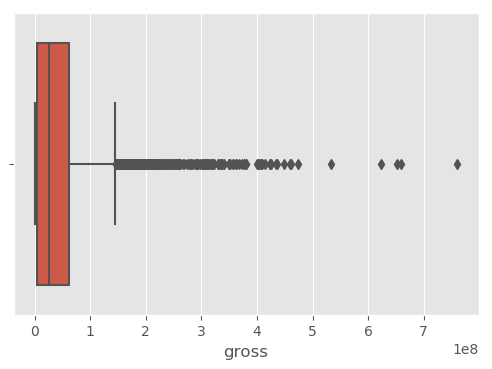

In [45]:
sns.boxplot(data['gross']);

Les valeurs de cette variable semblent consistantes. 

Cependant, cette variable, contrairement aux autres, présente beaucoup de valeurs manquantes. Nous utilisons une régression linéaire pour tenter de les prédire à l'aide des autres variables indépendantes.

In [46]:
train = data[data['gross'].notnull()]
test = data[data['gross'].isnull()]

X_train, y_train = train.drop(['gross'], axis=1), train['gross']
X_test = test.drop(['gross'], axis=1)

In [47]:
gross_model = LinearRegression()
gross_model.fit(X_train, y_train)
gross_filled = gross_model.predict(X_test)
data.loc[data['gross'].isnull(), 'gross'] = gross_filled

Comme pour le reste des variables numériques, ajustons son étendue dans l'intervalle [0, 1].

In [48]:
gross_scale = MinMaxScaler()
gross_var = data['gross']
data['gross'] = gross_scale.fit_transform(gross_var.values.reshape(-1, 1))

Affichons un résumé de nos variables en guise de `sanity check`

In [49]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
actor_1_facebook_likes,4919.0,0.010130,0.023584,0.000000,0.000949,0.001534,0.017188,1.0
actor_1_name,4919.0,0.169584,0.198854,0.020408,0.020408,0.081633,0.244898,1.0
actor_2_facebook_likes,4919.0,0.011813,0.029236,0.000000,0.002029,0.004328,0.006657,1.0
actor_2_name,4919.0,0.137985,0.124553,0.050000,0.050000,0.100000,0.200000,1.0
actor_3_facebook_likes,4919.0,0.027380,0.070510,0.000000,0.005761,0.016000,0.027435,1.0
actor_3_name,4919.0,0.248120,0.177233,0.125000,0.125000,0.125000,0.375000,1.0
aspect_ratio,4919.0,0.571503,0.175952,0.000000,0.424051,0.572610,0.740506,1.0
cast_total_facebook_likes,4919.0,0.014579,0.027652,0.000000,0.002123,0.004635,0.020726,1.0
color,4919.0,0.958528,0.199399,0.000000,1.000000,1.000000,1.000000,1.0
director_facebook_likes,4919.0,0.029452,0.121916,0.000000,0.000304,0.002130,0.008174,1.0


Et enfin, exportons nos fichiers finaux

In [50]:
data.to_csv('data/cleaned_data.csv')
movies.to_csv('data/movies.csv')

## Exploration avec t-SNE

Nous utilisons l'algorithme t-SNE afin de projeter notre jeu de données nettoyé dans un espace de deux dimensions afin de pouvoir le visualiser. Cela nous permettra d'avoir une première idée de la similarité des instances entre elles.

In [51]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(data)

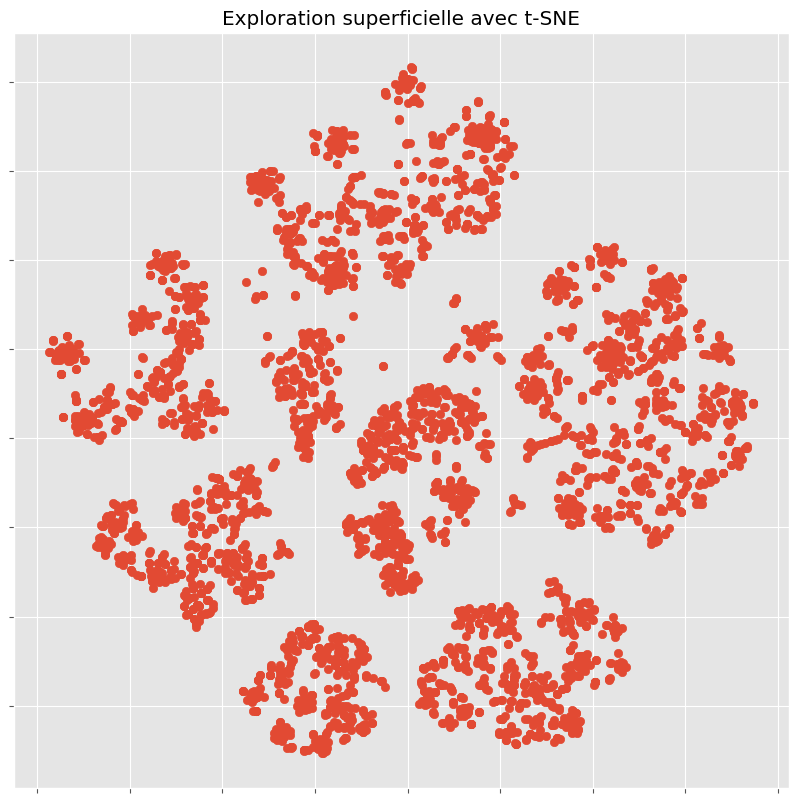

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.scatter(Y[:, 0], Y[:, 1])
ax.set_title("Exploration superficielle avec t-SNE")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
#plt.axis('tight');

D'après cette première exploration, entre 8 et 10 grands groupes d'instances semblent se dessiner.